1. 패키지 불러오기

In [1]:
#패키지(라이브러리) 불러오기

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

2. 필요한 변수 생성

In [2]:
#변수 생성 

AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

#데이터 경로

ROOT_PATH = os.path.join(os.getenv('HOME'),'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 5

print(ROOT_PATH)

/aiffel/aiffel


3. 데이터 개수 확인하기 

In [3]:
#train, test, val 개수 확인 

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
#데이터 모으기 

filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

#데이터를 나누기 

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
#정상 이미지와 폐렴 이미지 개수 확인 

print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [7]:
# mini-batch  사용 

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
#train, validation 데이터셋 재확인! 

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


3. 데이터 조정?

In [9]:
#라벨데이터 함수 

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts [-2] == "PNEUMONIA"

In [10]:
#이미지 형식 변경

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

#이미지와 라벨 읽어오기 

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
#이미지 확인 

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


4. test 데이터셋 만들기  

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

5. 데이터 시각화

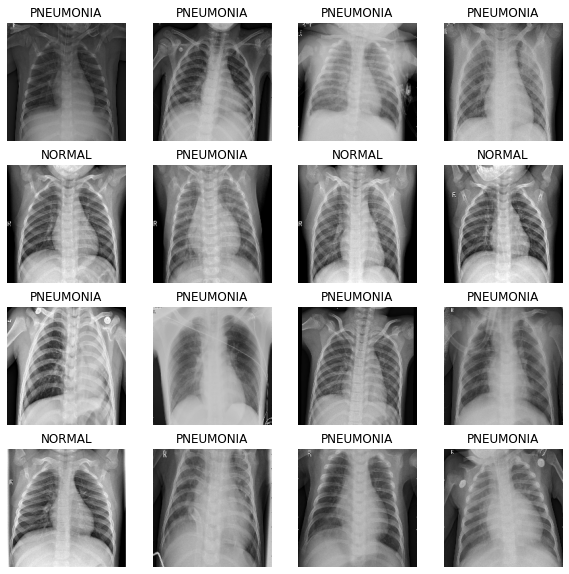

In [15]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

6. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block
    

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

7. imbalance한 데이터 처리하기

In [19]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


8. 드디어! 모델훈련!! 

In [20]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy', 
        tf.keras.metrics.Precision(name = 'precision'), 
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
        optimizer = 'adam', 
        loss = 'binary_crossentropy',
        metrics = METRICS)

In [21]:
#커널이 계속 죽어서 ㅠㅠ 에포크를 5로 바꿨습니다!
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/5
261/261 [==============================] - 68s 207ms/step - loss: 0.3841 - accuracy: 0.8151 - precision: 0.9538 - recall: 0.7898 - val_loss: 0.6906 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 53s 202ms/step - loss: 0.2409 - accuracy: 0.9133 - precision: 0.9761 - recall: 0.9058 - val_loss: 1.0481 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 53s 204ms/step - loss: 0.1791 - accuracy: 0.9301 - precision: 0.9802 - recall: 0.9247 - val_loss: 0.1384 - val_accuracy: 0.9558 - val_precision: 0.9959 - val_recall: 0.9436
Epoch 4/5
261/261 [==============================] - 54s 207ms/step - loss: 0.1838 - accuracy: 0.9325 - precision: 0.9800 - recall: 0.9282 - val_loss: 0.1058 - val_accuracy: 0.9548 - val_precision: 0.9487 - val_recall: 0.9921
Epoch 5/5
261/261 [==============================] - 55s 210ms/step - loss: 0.1652 - accuracy: 0

9. 두근두근 결과 확인

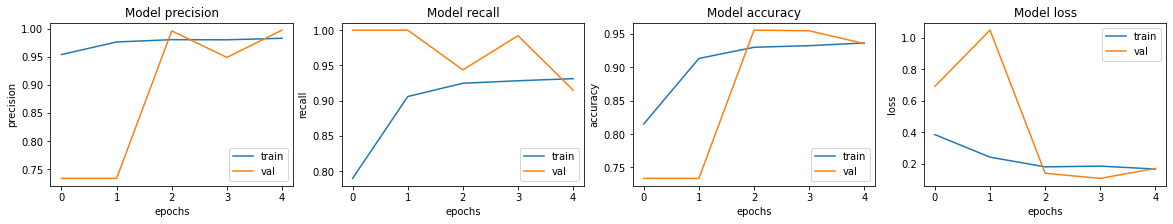

In [22]:
fig, ax = plt.subplots(1,4, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])    

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 129ms/step - loss: 0.4444 - accuracy: 0.8446 - precision: 0.8220 - recall: 0.9590
Loss: 0.44441550970077515,
Accuracy: 0.8445512652397156,
Precision: 0.8219780325889587,
Recall: 0.9589743614196777


## 1. 실험환경 수정

In [62]:
#변수 생성 

AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

#데이터 경로

ROOT_PATH = os.path.join(os.getenv('HOME'),'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 8 #5-> 8로 조정. 이것도 안 돌아가면 넌 딥러닝이 아니다. 난 널 강하게 키웠다. 

print(ROOT_PATH)

/aiffel/aiffel


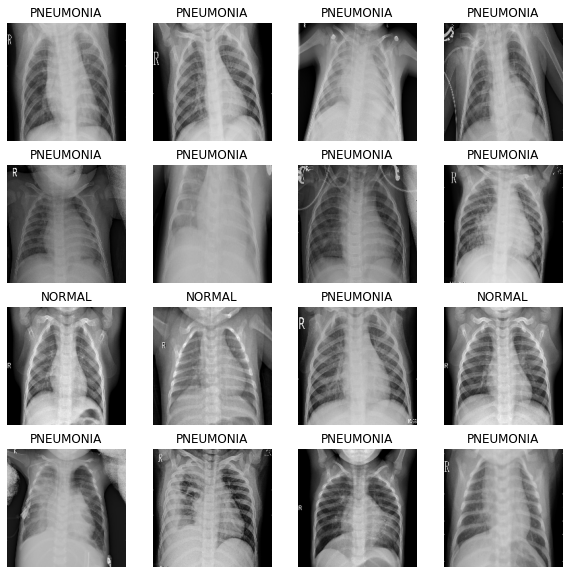

In [63]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE/4), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 2. ResNet-18 구현 도전..!!!! 

In [76]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense, ZeroPadding2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import time
import math
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import random
from keras.preprocessing.image import ImageDataGenerator

In [93]:
def conv3x3(in_planes : int, out_planes : int, stride : int=1, groups : int =1, dilation : int=1) -> nn.Conv2d:
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=dilation, 
                     groups=groups, bias=False, dilation =dilation)

def conv1x1(in_planes : int, out_planes : int, stride : int=1) -> nn.Conv2d:
    "1x1 convolution"
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride = stride, bias=False)

In [97]:
class BasicBlock(nn.Module):
    def __init__(
        self,
        inplanes:int,
        planes:int,
        stride:int=1,
        downsample: Optional[nn.Module]=None,
        groups:int=1,
        dilation:int=1,
        norm_layer: Optional[Callable[..., nn.Module]]=None
    )-> None:
        super(BasicBlock,self).__init__()
        
        #Normalization layer
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv1= conv3x3(inplanes, planes, stride)
        self.bn1=norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2= norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x:Tensor)-> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
       
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity #residual connection
        out = self.relu(out)
        return out

In [98]:
class ResNet(nn.Module):
    def __init__(
    self,
    block:Type[Union[BasicBlock, Bottleneck]],
    layers:List[int],
    num_classes : int=1000,
    zero_init_residual : bool=False,
    norm_layer: Optional[Callable[..., nn.Module]]=None
    )-> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer #batch norm layer
        self.inplanes = 64 #input shape
        self.dilation = 1 
        self.groups = 1
        
        #input block
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride =2, padding =3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride= 2, padding=1)
        
        #residual blocks
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=False)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=False)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512,num_classes)
        
        #weight initalizaiton
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity = 'relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            # zero-initialize the last BN in each residual branch
            # so that the residual branch starts with zero, and each residual block behaves like an identity
            # Ths improves the model by 0.2~0.3%
            if zero_init_residual:
                for m in self.modules():
                    if isinstance(m, Bottleneck):
                        nn.init.constant_(m.bn3.weight, 0)
                    elif isinstance(m, BasicBlock):
                        nn.init.constant_(m.bn2.weight, 0)
            
    def _make_layer(self, block:Type[Union[BasicBlock, Bottleneck]],
                   planes:int, blocks:int, stride: int=1, dilate:bool=False)->nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        #downsampling 필요한 경우 downsample layer 생성
        if stride !=1 or self.inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                norm_layer(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups, self.dilation, norm_layer))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups, dilation = self.dilation, 
                               norm_layer = norm_layer))

        return nn.Sequential(*layers)
    
    def forward(self, x:Tensor) -> Tensor:
        print('input shape:', x.shape)
        x = self.conv1(x)
        print('conv1 shape:', x.shape)
        x = self.bn1(x)
        print('bn1 shape:', x.shape)
        x = self.relu(x)
        print('relu shape:', x.shape)
        x = self.maxpool(x)
        print('maxpool shape:', x.shape)

        x = self.layer1(x)
        print('layer1 shape:', x.shape)
        x = self.layer2(x)
        print('layer2 shape:', x.shape)
        x = self.layer3(x)
        print('layer3 shape:', x.shape)
        x = self.layer4(x)
        print('layer4 shape:', x.shape)

        x = self.avgpool(x)
        print('avgpool shape:', x.shape)
        x = torch.flatten(x, 1)
        print('flatten shape:', x.shape)
        x = self.fc(x)
        print('fc shape:', x.shape)

        return x

In [116]:
model = ResNet(BasicBlock, [2, 2, 2, 2])
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [117]:
x = torch.randn(1,3,112,112)
model(x).shape

input shape: torch.Size([1, 3, 112, 112])
conv1 shape: torch.Size([1, 64, 56, 56])
bn1 shape: torch.Size([1, 64, 56, 56])
relu shape: torch.Size([1, 64, 56, 56])
maxpool shape: torch.Size([1, 64, 28, 28])
layer1 shape: torch.Size([1, 64, 28, 28])
layer2 shape: torch.Size([1, 128, 14, 14])
layer3 shape: torch.Size([1, 256, 7, 7])
layer4 shape: torch.Size([1, 512, 4, 4])
avgpool shape: torch.Size([1, 512, 1, 1])
flatten shape: torch.Size([1, 512])
fc shape: torch.Size([1, 1000])


torch.Size([1, 1000])

In [154]:
input_shape = (224,224,3)
num_classes = 2

model_a= resnet_18(input_shape, num_classes)

model_a.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_47 (BatchNo (None, 112, 112, 64) 256         conv2d_42[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 112, 112, 64) 0           batch_normalization_47[0][0]     
____________________________________________________________________________________________

### 3. imbalance한 데이터 처리

In [91]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 4. 모델 훈련

IndentationError: unexpected indent (3098522521.py, line 6)

In [172]:
model_a.compile(optimizer=Adam(learning_rate=0.001),loss='SparseCategoricalCrossentropy',metrics=['accuracy'])

In [173]:
def resize_image(image, label):
    image = tf.image.resize(image, (224,224))
    return image, label

train_ds = train_ds.map(resize_image)
val_ds = val_ds.map(resize_image)

with tf.device('/GPU:0'):
    history = model_a.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/8
261/261 [==============================] - 64s 202ms/step - loss: 0.3137 - accuracy: 0.8815 - val_loss: 1.8243 - val_accuracy: 0.7337
Epoch 2/8
261/261 [==============================] - 53s 204ms/step - loss: 0.1969 - accuracy: 0.9258 - val_loss: 0.9551 - val_accuracy: 0.5769
Epoch 3/8
261/261 [==============================] - 54s 206ms/step - loss: 0.1540 - accuracy: 0.9406 - val_loss: 0.7176 - val_accuracy: 0.7404
Epoch 4/8
261/261 [==============================] - 54s 206ms/step - loss: 0.1208 - accuracy: 0.9485 - val_loss: 0.2606 - val_accuracy: 0.8788
Epoch 5/8
261/261 [==============================] - 55s 211ms/step - loss: 0.1100 - accuracy: 0.9567 - val_loss: 1.4037 - val_accuracy: 0.6038
Epoch 6/8
261/261 [==============================] - 56s 215ms/step - loss: 0.1002 - accuracy: 0.9583 - val_loss: 0.2934 - val_accuracy: 0.9346
Epoch 7/8
261/261 [==============================] - 58s 222ms/step - loss: 0.0983 - accuracy: 0.9624 - val_loss: 0.4518 - val_accuracy:

### 5. 결과 확인

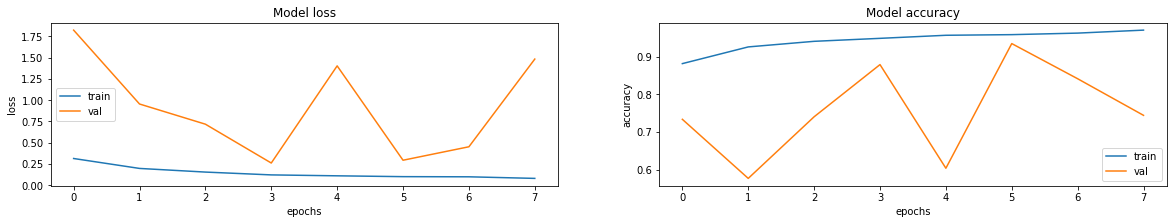

In [175]:
fig, ax = plt.subplots(1,2, figsize = (20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val']) 

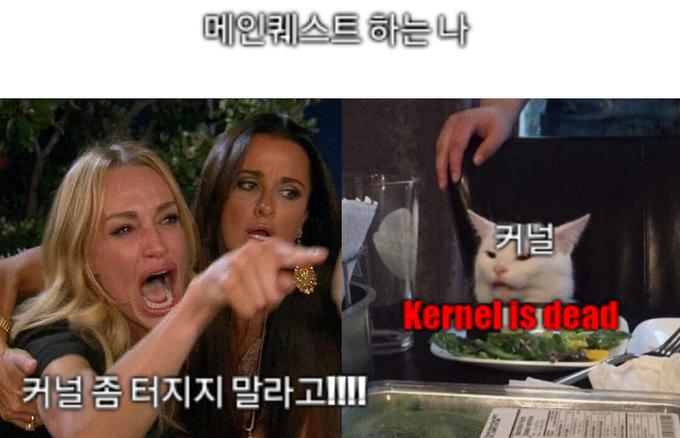  

내 심정이 이러하다.   
커널이 계속 죽어서 너무너무 힘들었다.   
그래도 어째저째 했다.  
자식같은 코드입니다.  
예쁘게 봐주세요. 